In [ ]:
!wget https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz
!tar -xzvf babi_tasks_1-20_v1-2.tar.gz

--2022-07-15 14:36:42--  https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.171.72
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.171.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11745123 (11M) [application/x-gzip]
Saving to: ‘babi_tasks_1-20_v1-2.tar.gz’

babi_tasks_1-20_v1- 100%[===================>]  11.20M  6.07MB/s    in 1.8s    

2022-07-15 14:36:44 (6.07 MB/s) - ‘babi_tasks_1-20_v1-2.tar.gz’ saved [11745123/11745123]

tasks_1-20_v1-2/
tasks_1-20_v1-2/en-10k/
tasks_1-20_v1-2/en-10k/qa12_conjunction_train.txt
tasks_1-20_v1-2/en-10k/qa11_basic-coreference_test.txt
tasks_1-20_v1-2/en-10k/qa4_two-arg-relations_train.txt
tasks_1-20_v1-2/en-10k/qa20_agents-motivations_train.txt
tasks_1-20_v1-2/en-10k/qa18_size-reasoning_test.txt
tasks_1-20_v1-2/en-10k/qa5_three-arg-relations_test.txt
tasks_1-20_v1-2/en-10k/qa12_conjunction_test.txt
tasks_1-20_v1-2/en-10k/qa2_two-supporting-

In [ ]:
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
max_vocab=20000
emb_dim=15
max_sen=2

In [ ]:
train_set=open("./tasks_1-20_v1-2/en/qa1_single-supporting-fact_train.txt")
test_set=open("./tasks_1-20_v1-2/en/qa1_single-supporting-fact_test.txt")

In [ ]:
def getting_x_y(data):
    first_sen_story=[]
    second_sen_story=[]
    questions=[]
    answers=[]
    t=1
    for line in data:
        line=line[2:]
        if t==1:
            first_sen_story.append(line)
            t+=1
        elif t==2:
            second_sen_story.append(line)
            t+=1
        else:
            q,a,_=line.split("\t")
            questions.append(q)
            answers.append(a)
            t=1
    return first_sen_story,second_sen_story,questions,answers    
   

In [ ]:
train_first_sen_story,train_second_sen_story,train_questions,train_answers=getting_x_y(train_set)
test_first_sen_story,test_second_sen_story,test_questions,test_answers=getting_x_y(test_set)

In [ ]:
story_tokenizer=Tokenizer(num_words=max_vocab)
story_tokenizer.fit_on_texts(train_first_sen_story+train_second_sen_story+test_first_sen_story+test_second_sen_story)
train_first_seq_story=story_tokenizer.texts_to_sequences(train_first_sen_story)
train_second_seq_story=story_tokenizer.texts_to_sequences(train_second_sen_story)
test_first_seq_story=story_tokenizer.texts_to_sequences(test_first_sen_story)
test_second_seq_story=story_tokenizer.texts_to_sequences(test_second_sen_story)

In [ ]:
max_story_sen_length=max(max(len(s) for s in train_first_seq_story ),max(len(s) for s in train_second_seq_story ),max(len(s) for s in test_first_seq_story ),max(len(s) for s in test_second_seq_story ))

In [ ]:
train_first_seq_story=pad_sequences(train_first_seq_story,maxlen =max_story_sen_length,padding = "post")
train_second_seq_story=pad_sequences(train_second_seq_story,maxlen =max_story_sen_length,padding = "post")
test_first_seq_story=pad_sequences(test_first_seq_story,maxlen =max_story_sen_length,padding = "post")
test_second_seq_story=pad_sequences(test_second_seq_story,maxlen =max_story_sen_length,padding = "post")

In [ ]:
questions_tokenizer=Tokenizer(num_words=max_vocab)
questions_tokenizer.fit_on_texts(train_questions+test_questions)
train_seq_questions=questions_tokenizer.texts_to_sequences(train_questions)
test_seq_questions=questions_tokenizer.texts_to_sequences(test_questions)

In [ ]:
max_questions_sen_length=max(max(len(s) for s in train_seq_questions ),max(len(s) for s in test_seq_questions) )

In [ ]:
train_seq_questions=pad_sequences(train_seq_questions,maxlen =max_questions_sen_length,padding = "post")

test_seq_questions=pad_sequences(test_seq_questions,maxlen =max_questions_sen_length,padding = "post")



In [ ]:
answers_tokenizer=Tokenizer(num_words=max_vocab)
answers_tokenizer.fit_on_texts(train_answers+test_answers)
train_seq_answers=answers_tokenizer.texts_to_sequences(train_answers)

test_seq_answers=answers_tokenizer.texts_to_sequences(test_answers)
max_answers_sen_length=max(max(len(s) for s in train_seq_answers ),max(len(s) for s in test_seq_answers) )

In [ ]:
train_seq_answers=pad_sequences(train_seq_answers,maxlen =max_answers_sen_length,padding = "post")

test_seq_answers=pad_sequences(test_seq_answers,maxlen =max_answers_sen_length,padding = "post")


In [ ]:
def stack_stories(data1,data2):
    data=[]
    for i in range(len(data1)):
        data.append([data1[i],data2[i]])
    return np.asarray(data)   

In [ ]:
train_stories=stack_stories(train_first_seq_story,train_second_seq_story)
test_stories=stack_stories(test_first_seq_story,test_second_seq_story)

In [ ]:
word2index=answers_tokenizer.word_index
train_seq_answers=to_categorical(train_seq_answers)
test_seq_answers=to_categorical(test_seq_answers)

In [ ]:
story_input=keras.layers.Input(shape=(max_sen,max_story_sen_length,))
story_emb=keras.layers.Embedding(max_vocab,emb_dim)
x=story_emb(story_input)
# the output of x is (2,max_story_sen_length,emb_dim)
# model=keras.Model(story_input,x)
sum_of_two_stories=keras.layers.Lambda(lambda x:keras.backend.sum(x,axis=2))
s=sum_of_two_stories(x)
# the output of s is (1,max_story_sen_length,emb_dim)
# so its only add them
# model1=keras.Model(story_input,s)
question_input=keras.layers.Input(shape=(max_questions_sen_length,))
question_emb=keras.layers.Embedding(max_vocab,emb_dim)
output_of_question_emb=question_emb(question_input)
sum_question=keras.layers.Lambda(lambda x:keras.backend.sum(x,axis=1))
output_of_sum_question=sum_question(output_of_question_emb)
# the output of output_of_question_emb is (1,emb_dim)
# so its only add them
question_reshape=keras.layers.Reshape((1,emb_dim))
output_of_question_reshape=question_reshape(output_of_sum_question)
# it reshape them into 3 dim  only
# model2=keras.Model(question_input,output_of_sum_question)
# model3=keras.Model(question_input,output_of_question_reshape)
mul_story_with_question=keras.layers.dot([s,output_of_question_reshape],2)
flatten_=keras.layers.Flatten()

the_output_flatten=flatten_(mul_story_with_question)
# model4=keras.Model([story_input,question_input],mul_story_with_question)
# model5=keras.Model([story_input,question_input],the_output_flatten)

get_story_weights=keras.layers.Activation('softmax')(the_output_flatten)
story_weigths=keras.layers.Reshape((max_sen,1))(get_story_weights)
debug_model=keras.Model([story_input,question_input],story_weigths)
mul_weight_with_story=keras.layers.dot([story_weigths,s],1)
flatten2_=keras.layers.Flatten()
y=flatten2_(mul_weight_with_story)
y=keras.layers.Dense(len(word2index)+1,activation="softmax")(y)
model=keras.Model([story_input,question_input],y)

In [ ]:
model.compile("adam",loss=keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])

In [ ]:
history=model.fit([train_stories,train_seq_questions],train_seq_answers,batch_size=32,epochs=50
          ,validation_data=([test_stories,test_seq_questions],test_seq_answers))

Epoch 1/50
32/32 [==============================] - 2s 17ms/step - loss: 1.9261 - accuracy: 0.2060 - val_loss: 1.8778 - val_accuracy: 0.2980
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 1.8460 - accuracy: 0.3340 - val_loss: 1.8125 - val_accuracy: 0.3430
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 1.7842 - accuracy: 0.3730 - val_loss: 1.7605 - val_accuracy: 0.3930
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 1.7306 - accuracy: 0.4260 - val_loss: 1.7144 - val_accuracy: 0.4170
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 1.6806 - accuracy: 0.4440 - val_loss: 1.6718 - val_accuracy: 0.4230
Epoch 6/50
32/32 [==============================] - 0s 9ms/step - loss: 1.6336 - accuracy: 0.4480 - val_loss: 1.6321 - val_accuracy: 0.4350
Epoch 7/50
32/32 [==============================] - 0s 10ms/step - loss: 1.5875 - accuracy: 0.4860 - val_loss: 1.5964 - val_accuracy: 0.4530
Epoch 8/50
32/32

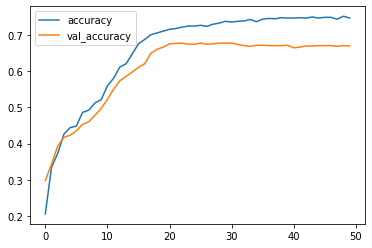

In [ ]:
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

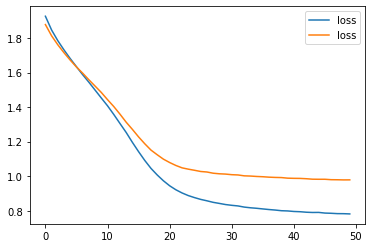

In [ ]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="loss")
plt.legend()
plt.show()

In [ ]:
i=np.random.choice(len(train_first_sen_story))
z=model.predict([train_stories[i:i+1],train_seq_questions[i:i+1]])
idx=np.argmax( z[0,:])
print(train_first_sen_story[i])
print(train_second_sen_story[i])
print(train_questions[i])
answers_tokenizer.index_word[idx]

Daniel moved to the bathroom.

Mary journeyed to the garden.

Where is Daniel? 


'bathroom'